<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="./images/DLI_Header.png"></a></div>

# Wide & Deep Neural Networks

Deep neural networks are good at generalizing information, but sometimes, it's useful to memorize information as well. For instance, say we're building a neural network to predict movie ratings. It would be nice if we could keep track of how highly praised [Citizen Kane](https://www.rottentomatoes.com/m/citizen_kane) is on average. This works for users as well. Some users have a more optimistic or critical lean in their ratings.

This is the power of [Wide & Deep](https://arxiv.org/abs/1606.07792) neural networks. The "wide" part keeps track of these simple averages so they doesn't get lost in the generalization of deep neural networks.

## Objectives

* Learn how to use TensorFlow Feature Columns
  * [1. Feature Columns](#1.-Feature-Columns)
    * [1.1 One-Hot Encoding](#1.1-One-Hot-Encoding)
    * [1.2 One-Hot Encoding by Hashing](#1.2-One-Hot-Encoding-by-Hashing)
    * [1.3 Crossed Columns](#1.3-Crossed-Columns)
* Learn how to build a Wide Neural Network
  * [2. Building a Wide Network](#2.-Building-a-Wide-Network)
  * [3. Adding in ALS](#3.-Adding-in-ALS)
* Combine Wide and Deep Neural Networks
  * [4. Wrap Up](#4.-Wrap-Up)

## 1. Feature Columns

Along with the many [layers available in Keras](https://keras.io/api/layers/), TensorFlow has it's own library for reading input data called [TensorFlow Feature Columns](https://www.tensorflow.org/api_docs/python/tf/feature_column). This [blog](https://medium.com/ml-book/demonstration-of-tensorflow-feature-columns-tf-feature-column-3bfcca4ca5c4) has an excellent overview of Feature Columns, but we're going to look at a few.

Let's start by loading the libraries we'll need for this lab.

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, concatenate, Dense, DenseFeatures
from tensorflow import feature_column

import dataset
import deep

import cudf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.1 One-Hot Encoding

Let's say we have a categorical column that's already been indexed. For example, we have `10` users that have been assigned an ID from `0` to `9`. Before, when we did this with Keras, the [Embedding layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) took care of one-hot encoding the data for us, but if we don't want to feed the encoding directly into an embedding, we can use [categorical_column_with_identity](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_identity).

In [5]:
max_id = 10  # 9 + 1 for id of 0
user_id_fc = feature_column.categorical_column_with_identity("userID", max_id)

Under the hood, TensorFlow saves this data as sparse, but for it to be read by our neural network model, it eventually needs to be in a dense format. The [indicator_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column) can do this conversion for us. Let's pass this and `user_list`, a fake batch input of users, to see what our Keras model would see. We can use the Keras [DenseFeatures](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DenseFeatures) layer to read our Feature Columns into Keras.

In [6]:
user_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
user_id_ic = feature_column.indicator_column(user_id_fc)
tf.keras.layers.DenseFeatures(user_id_ic)({"userID": user_list})

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

### 1.2 One-Hot Encoding by Hashing

Let's say our user IDs are stored as strings and it's not feasible to find the maximum id. In that case, we can [hash](https://en.wikipedia.org/wiki/Hash_function) our data into a specified number of buckets using [categorical_column_with_hash_bucket](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_hash_bucket). It's not as precise as [categorical_column_with_identity](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_identity), but can allow for more flexible data pipelines.

In [7]:
buckets = 5
user_id_fc = feature_column.categorical_column_with_hash_bucket("userID", buckets)
user_id_ic = feature_column.indicator_column(user_id_fc)
tf.keras.layers.DenseFeatures(user_id_ic)({"userID": [str(x) for x in user_list]})

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

More than one user might end up in the same bucket, but empirically, neural networks overcome this if given enough contextual information in the other features. Because we're representing many users in fewer dimensions, this is similar to an embedding in that it reduces the amount of computation for our network.

### 1.3 Crossed Columns

If we have multiple categorical columns, in our case, user IDs and brand IDs, we can combine them to make a type of multi-categorical column called a crossed column.

<img src="images/crossed_columns.png" width=500>

Rather than having two one-hot encoding columns, we can look at each combination of categories and one-hot encode that instead. This allows us to capture an interaction between two categories, something our current Deep Neural Network does not have.

Let's try and example. Let's say we have `3` users and `3` items we can recommend them.

In [8]:
number_of_users = 3
number_of_items = 3
user_id_fc = feature_column.categorical_column_with_identity(
    "userID", number_of_users
)
item_id_fc = feature_column.categorical_column_with_identity(
    "brandID", number_of_items
)

We can use [crossed_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) to construct our combined category and an [indicator_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column) to format it into dense data.

In [9]:
user_item_count = number_of_users * number_of_items
input_columns = [user_id_fc, item_id_fc]
user_x_items = feature_column.crossed_column(input_columns, user_item_count)
user_x_items = feature_column.indicator_column(user_x_items)

By running the cell below, we should see each unique combination of `userId` and `brandId` get its own one-hot encoding.

In [10]:
tf.keras.layers.DenseFeatures(user_x_items)(
    {"userID": [0, 0, 0, 1, 1, 1, 2, 2, 2], "brandID": [0, 1, 2, 0, 1, 2, 0, 1, 2]}
)

<tf.Tensor: shape=(9, 9), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>

It's good to note that crossing categorical features creates especially sparse data, so this type of strategy works best when our dataset has many different combinations of categories to train on. Why not cross `userId` with `itemId`? We could, but it would be ineffective. If we're trying to make recommendations for items that the user has not yet rated, then our training dataset wouldn't have the user item combinations that we're trying to predict for.

## 2. Building a Wide Network

Now that we have all of the pieces to build a Wide & Deep network, let's put them together! We'll build two functions:
1. get_deep: to build a deep network
2. get_wide: to build a wide network

First, let's define our inputs for the deep network. We'll need our data.

In [11]:
ratings = cudf.read_csv("./data/wide_and_deep.csv")

We also need our set of input functions.

In [12]:
input_tensor = {
    "user_index": Input(name="user_index", shape=(1,), dtype="int64"),
    "item_index": Input(name="item_index", shape=(1,), dtype="int64"),
    "brand_index": Input(name="brand_index", shape=(1,), dtype="int64"),
    "price_filled": Input(name="price_filled", shape=(1,), dtype="float32"),
    "salesRank_Electronics": Input(name="salesRank_Electronics", shape=(1,), dtype="float32"),
    "category_0_2_index": Input(name="category_0_2_index", shape=(1,), dtype="int32"),
    "category_1_2_index": Input(name="category_1_2_index", shape=(1,), dtype="int32"),
}

Finally, add the different types of data the deep network will be ingesting.

In [13]:
one_hot_columns = ["user_index", "item_index", "brand_index"]
numerical_columns = ["price_filled", "salesRank_Electronics"]
multi_hot_columns = ["category_0_2_index", "category_1_2_index"]

Please correct the `FIXME`s below to build the `get_deep` function. There is one for each input. If done correctly, the next cell should output the same graph as found at the end of the [previous notebook](2-03_deep_nn.ipynb). Click the `...` for a solution.

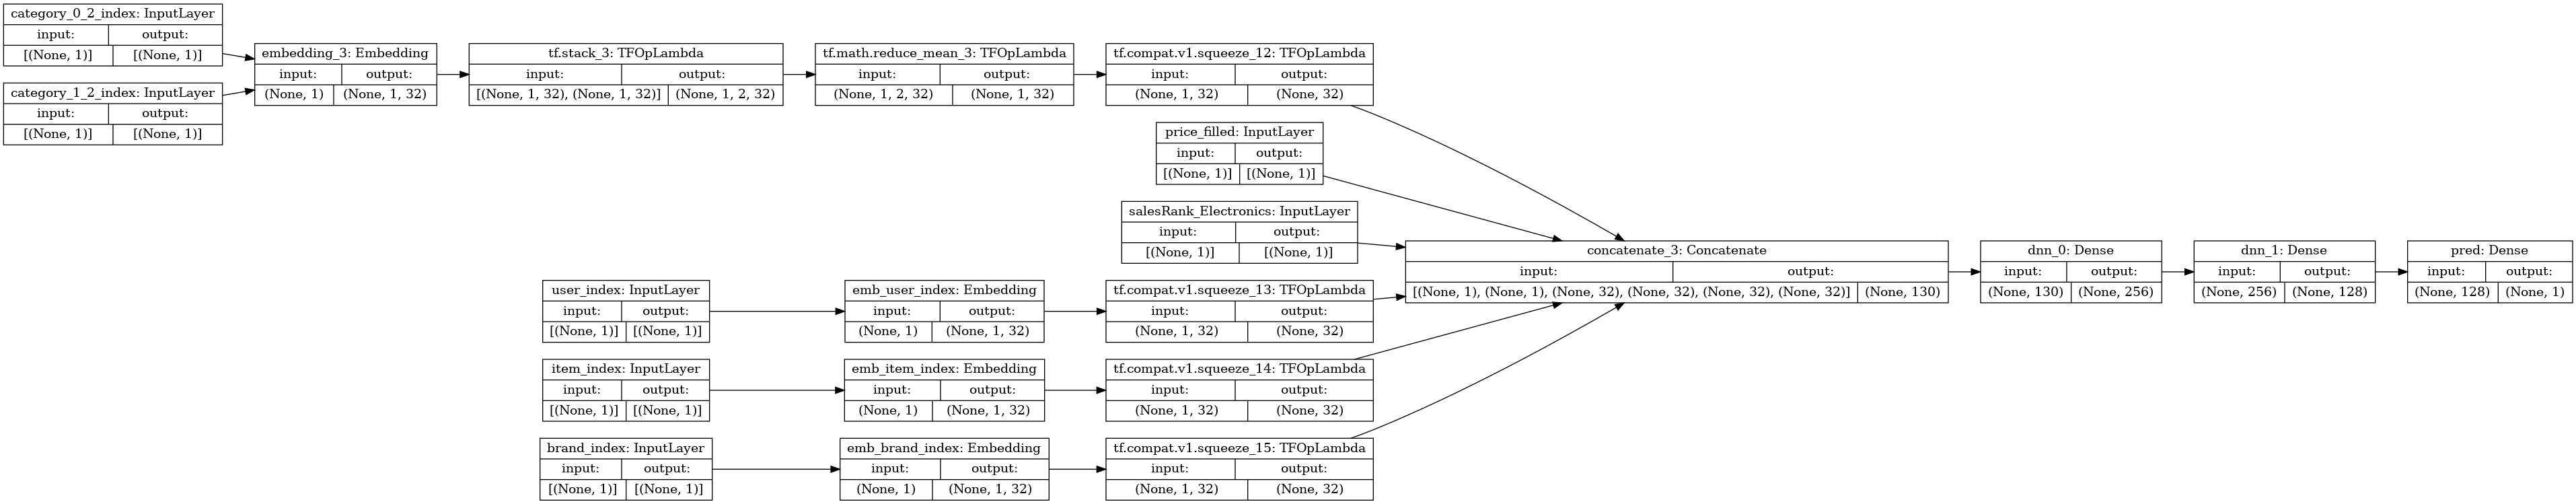

In [20]:
def get_deep(
    ratings,
    input_tensor,
    one_hot_columns,
    numerical_columns,
    multi_hot_columns,
    embedding_size=32
):
    FIXME_A = one_hot_columns
    FIXME_B = input_tensor
    FIXME_C = numerical_columns
    FIXME_D = ratings
    FIXME_E = multi_hot_columns
    FIXME_F = embedding_size

    # Get One-hot embeddings
    embedding_inputs = {key: input_tensor[key] for key in FIXME_A}

    # Get numerical layers to concatenate with embeddings
    numerical_layers = [FIXME_B[col] for col in FIXME_C]

    # Get multihot embeddings
    doc_max = max(FIXME_D[FIXME_E].to_pandas().max())
    multihot_emb = Embedding(int(doc_max + 1), FIXME_F)
    multihot_emb_ids = [multihot_emb(FIXME_B[col]) for col in FIXME_E]
    multihot_emb_stack = tf.keras.backend.stack(multihot_emb_ids, axis=2)
    multihot_emb_avg = tf.squeeze(tf.keras.backend.mean(multihot_emb_stack, axis=2), axis=1)

    concatenate_layers = numerical_layers + [multihot_emb_avg]
    output_tensor_deep = deep.get_model(
        embedding_inputs=embedding_inputs, concatenate_layers=concatenate_layers
    )
    return tf.keras.Model(FIXME_B, output_tensor_deep), output_tensor_deep


deep_model, output_tensor_deep = get_deep(
    ratings, input_tensor, one_hot_columns, numerical_columns, multi_hot_columns
)
tf.keras.utils.plot_model(deep_model, show_shapes=True, rankdir="LR")


We're making progress! Let's make the `get_wide` function next. First, we'll define the columns we'll use for our `crossed_columns` and `wide_input_tensor` specific to the wide architecture.

In [21]:
crossed_columns = [('user_index', 'brand_index')]

As before, please fix the following code. There is a `FIXME` for each input.

In [22]:
def get_wide(
    ratings, input_tensor, one_hot_columns, crossed_columns, embedding_size=128,
):
    FIXME_A = ratings
    FIXME_B = one_hot_columns
    FIXME_C = embedding_size
    FIXME_D = crossed_columns
    FIXME_E = input_tensor
    
    cat_identity = {}
    for col in FIXME_B:
        number_of_buckets = int(FIXME_A[col].to_pandas().max() + 1)
        cat_identity[col] = tf.feature_column.categorical_column_with_identity(
            col, number_of_buckets)

    cat_indicator = {
        col: tf.feature_column.indicator_column(cat_identity[col])
        for col in cat_identity
    }

    cat_cross = {}
    for col1, col2 in FIXME_D:
        key = col1 + "_" + col2
        crossed_column = tf.feature_column.crossed_column(
            [cat_identity[col1], cat_identity[col2]], FIXME_C
        )
        cat_cross[key] = tf.feature_column.indicator_column(crossed_column)


    cat_indicator.update(cat_cross)
    dense_features = cat_indicator.values()
    dense_features = DenseFeatures(dense_features, name="deep_inputs")(FIXME_E)
    return Dense(1, activation=None, name="output_wide")(dense_features)


output_tensor_wide = get_wide(ratings, input_tensor, one_hot_columns, crossed_columns)

In [ ]:
FIXME_A = ratings
FIXME_B = one_hot_columns
FIXME_C = embedding_size
FIXME_D = crossed_columns
FIXME_E = input_tensor

Alright, let's combine everything into one big model!

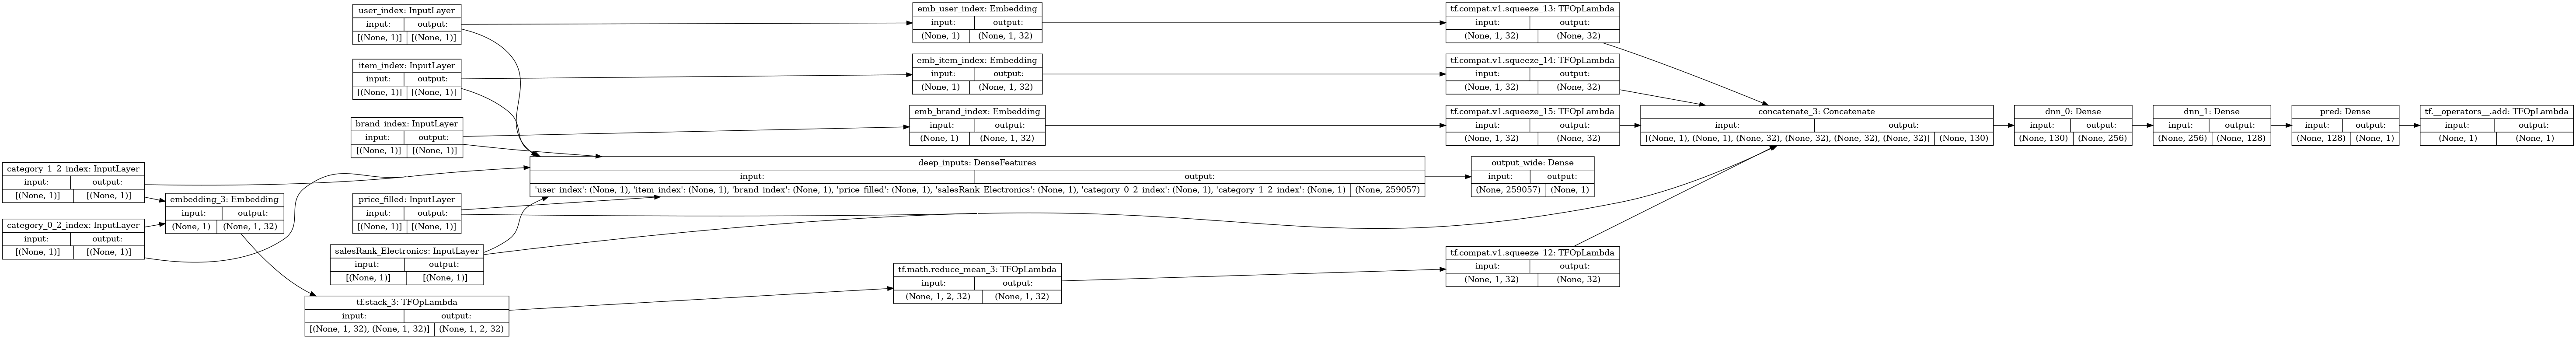

In [23]:
output_tensor = output_tensor_deep + output_tensor_wide

model = tf.keras.Model(input_tensor, output_tensor)
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

Run the code below to finally see if see if we can get below a `1.14` RMSE.

In [24]:
train_ds, valid_ds = dataset.get_test_and_train(one_hot_columns+multi_hot_columns, numerical_columns, df=ratings)

In [25]:
from nvtabular.loader.tensorflow import KerasSequenceValidater

metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")]
model.compile(optimizer="adam", loss="mse", metrics=metrics)
model.fit(train_ds, callbacks=[KerasSequenceValidater(valid_ds)], epochs=2)

Epoch 1/2
1462/1462 [==============================] - 116s 78ms/step - loss: 2.1923 - rmse: 1.4194
{'val_loss': 2.4157271, 'val_rmse': 1.1845251}
Epoch 2/2
1462/1462 [==============================] - 113s 77ms/step - loss: 0.9888 - rmse: 0.9943
{'val_loss': 2.1616404, 'val_rmse': 1.0273868}


We're very close! Let's save this model and use it for our production system.

In [26]:
model.save("task2_model", overwrite=True)

INFO:tensorflow:Assets written to: task2_model/assets


We can save our trained model as a zip file by running the below cell, and download the `task2_model.zip` file that appears on the file menu to the left (the file list may need to be refreshed for the zip file to appear).

In [27]:
!zip -r ./data/task2_model.zip ./task2_model

  adding: task2_model/ (stored 0%)
  adding: task2_model/saved_model.pb (deflated 89%)
  adding: task2_model/assets/ (stored 0%)
  adding: task2_model/variables/ (stored 0%)
  adding: task2_model/variables/variables.index (deflated 67%)
  adding: task2_model/variables/variables.data-00000-of-00001 (deflated 6%)


## 3. Adding in ALS

If you can't beat them, why not join 'em? Chaining our models like this is perfectly valid, and as we'll learn in the next section, can be extremely useful in at-scale production systems. While in this case our ALS model has a slightly bigger RMSE than our Wide & Deep network, it still has the ability to capture features a neural network cannot.

We have 5 columns from ALS that we can add: 
`als_prediction`, `user_embed_0`, `user_embed_1`, `item_embed_0`, and `item_embed_1`. For our current data, adding our `als_prediction` will lead to overfitting, but to see how such a pipeline could work, try running the cells below.

In [28]:
tf.keras.backend.clear_session()

# Add ALS features
input_tensor = {
    "user_index": Input(name="user_index", shape=(1,), dtype="int64"),
    "item_index": Input(name="item_index", shape=(1,), dtype="int64"),
    "brand_index": Input(name="brand_index", shape=(1,), dtype="int64"),
    "price_filled": Input(name="price_filled", shape=(1,), dtype="float32"),
    "salesRank_Electronics": Input(
        name="salesRank_Electronics", shape=(1,), dtype="float32"
    ),
    "category_0_2_index": Input(name="category_0_2_index", shape=(1,), dtype="int64"),
    "category_1_2_index": Input(name="category_1_2_index", shape=(1,), dtype="int64"),
    "als_prediction": Input(name="als_prediction", shape=(1,), dtype="float32"),  # Added
}

# Add ALS features
one_hot_columns = ["user_index", "item_index", "brand_index"]
numerical_columns = ["price_filled", "salesRank_Electronics", "als_prediction"]  # Added
multi_hot_columns = ["category_0_2_index", "category_1_2_index"]
crossed_columns = [("user_index", "brand_index")]

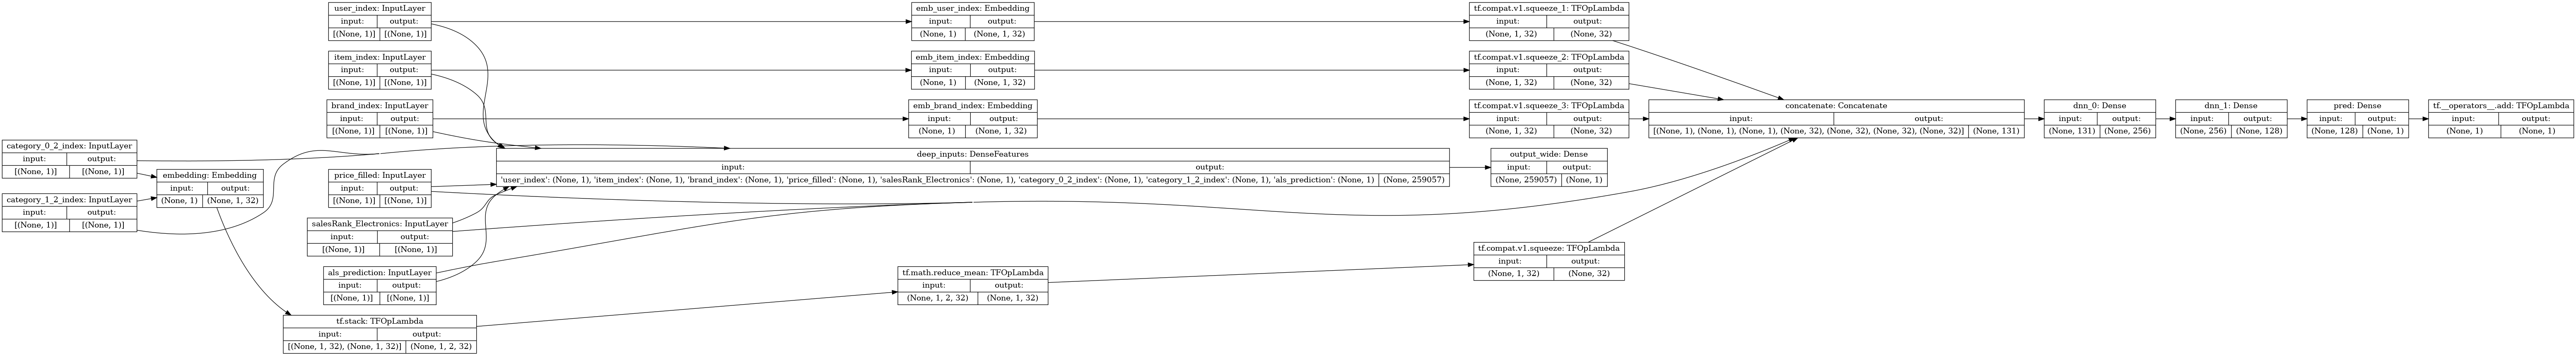

In [29]:
deep_model, output_tensor_deep = get_deep(
    ratings, input_tensor, one_hot_columns, numerical_columns, multi_hot_columns
)
output_tensor_wide = get_wide(ratings, input_tensor, one_hot_columns, crossed_columns)
output_tensor = output_tensor_deep + output_tensor_wide
model = tf.keras.Model(input_tensor, output_tensor)
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [30]:
train_ds, valid_ds = dataset.get_test_and_train(one_hot_columns+multi_hot_columns, numerical_columns,df=ratings)

In [31]:
from nvtabular.loader.tensorflow import KerasSequenceValidater

model.compile(optimizer="adam", loss="mse", metrics=metrics)
model.fit(train_ds, callbacks=[KerasSequenceValidater(valid_ds)], epochs=2)

Epoch 1/2
1462/1462 [==============================] - 110s 74ms/step - loss: 1.1678 - rmse: 1.0171
{'val_loss': 2.0983129, 'val_rmse': 1.0111037}
Epoch 2/2
1462/1462 [==============================] - 109s 74ms/step - loss: 0.8636 - rmse: 0.9293
{'val_loss': 2.0708122, 'val_rmse': 0.9667724}


## 4. Wrap Up

Congratulations on finishing this set of notebooks! We learned how to prepare ratings data for neural networks and how to build a Wide & Deep architecture. In the end, combining our different strategies was the best approach. Why is that? Have an idea? Head back over to the notebook launcher to find out.

Like last time, we can save our work by running the below cell and downloading the `lab2_work.zip` file that appears on the file menu to the left (the file list may need to be refreshed for the zip file to appear).

In [ ]:
!zip -r lab2_work.zip . -i '2*.ipynb'

import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="./images/DLI_Header.png"></a></div>